In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import pyzx
from typing import List,Tuple
from pyzx.graph.base import BaseGraph, VT, ET
import math
import random
import time
import matplotlib.pyplot as plt
import pyzx
from pyzx.graph.base import BaseGraph
from pyzx.graph import Graph
from typing import List, Tuple
import pennylane as qml
from tqdm import tqdm
import tempfile

In [2]:
#回路セット読み込み
#一分ぐらいかかる
[ds] = qml.data.load("op-t-mize")

pyzx_circuits = []

for i, qscript in enumerate(ds.circuits):
    try:
        # QuantumScript を OpenQASM 2.0 に変換
        qasm_str = qscript.to_openqasm(
            wires=None,
            rotations=False,
            measure_all=False,
            precision=8
        )

        # QASM を一時ファイル経由で PyZX に読み込む
        with tempfile.NamedTemporaryFile(suffix=".qasm", mode='w+', delete=False) as tmpfile:
            tmpfile.write(qasm_str)
            tmpfile.flush()
            zx_circuit = pyzx.Circuit.load(tmpfile.name)

        # 元の回路名を設定（PyZX Circuit に名前属性を追加）
        zx_circuit.name = ds.circuit_names[i]
        pyzx_circuits.append(zx_circuit)
        
    except Exception as e:
        print(f"回路 {i}（{ds.circuit_names[i]}）の変換に失敗: {e}")

#読み込んだ回路の確認
print(len(pyzx_circuits))
for i, zx_circuit in enumerate(pyzx_circuits):
    dict = zx_circuit.stats_dict()
    print(dict)

31
{'name': 'mod5_4', 'qubits': 5, 'gates': 63, 'tcount': 28, 'clifford': 35, 'twoqubit': 28, 'cnot': 28, 'had': 6, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}
{'name': 'vbe_adder_3', 'qubits': 10, 'gates': 150, 'tcount': 70, 'clifford': 80, 'twoqubit': 70, 'cnot': 70, 'had': 10, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}
{'name': 'csla_mux_3_original', 'qubits': 15, 'gates': 170, 'tcount': 70, 'clifford': 100, 'twoqubit': 80, 'cnot': 80, 'had': 20, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}
{'name': 'csum_mux_9_corrected', 'qubits': 30, 'gates': 448, 'tcount': 196, 'clifford': 252, 'twoqubit': 168, 'cnot': 168, 'had': 56, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}
{'name': 'qcla_com_7', 'qubits': 24, 'gates': 443, 'tcount': 203, 'clifford': 240, 'twoqubit': 186, 'cnot': 186, 'had': 39, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}
{'name': 'qcla_mod_7', 'qubits': 26, 'gates': 884, 'tcount': 413, 'clifford': 471, 'twoqub

In [ ]:

circuit = None
for zx_circuit in pyzx_circuits:
    if hasattr(zx_circuit, 'name') and zx_circuit.name == "adder_8":
        circuit = zx_circuit
        break

if circuit is not None:
    print(f"回路名: {circuit.name}")
    print(circuit.stats_dict())
else:
    print("回路は見つかりませんでした。")


g = pyzx.simplify.teleport_reduce(circuit.to_graph())
pyzx.draw(g,labels=True)
c = pyzx.Circuit.from_graph(g)
print(c.stats())

pyzx.draw(c,labels=True)
c_aft = pyzx.optimize.phase_block_optimize(c)
print(c_aft.stats())

回路名: adder_8
{'name': 'adder_8', 'qubits': 24, 'gates': 900, 'tcount': 399, 'clifford': 501, 'twoqubit': 409, 'cnot': 409, 'had': 80, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}


Circuit  on 24 qubits with 780 gates.
        173 is the T-count
        607 Cliffords among which
        409 2-qubit gates (409 CNOT, 0 other) and
        80 Hadamard gates.


Circuit  on 24 qubits with 977 gates.
        167 is the T-count
        810 Cliffords among which
        624 2-qubit gates (413 CNOT, 211 other) and
        80 Hadamard gates.


In [2]:
class SimulatedAnnealer_T:
    """
    Attributes:
        initial_temp (float): 初期温度
        final_temp (float): 最終温度
        cooling_rate (float): 冷却率 (0 < alpha < 1)
    """
    def __init__(self, initial_temp, final_temp, cooling_rate):
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate

    def _acceptance_probability(self, old_score, new_score, temp):
        if new_score < old_score:
            return 1.0
        if temp == 0:
            return 0.0
        delta_score = new_score - old_score
        return math.exp(-delta_score / temp)
    
    def solve(self, initial_state, evaluate_func):
        total_start_time = time.time()

        timings = {
            'evaluate_func': 0.0,
            'get_neighbor': 0.0,
            'acceptance_probability': 0.0,
            'state_update': 0.0,
            'history_update': 0.0,
            'print': 0.0,
            'cooling': 0.0,
            'loop_total': 0.0,
        }

        current_temp = self.initial_temp

        t0 = time.time()
        current_score = evaluate_func(initial_state)
        timings['evaluate_func'] += time.time() - t0

        current_state = initial_state
        best_state = current_state
        best_score = current_score

        history = {
            'score': [current_score],
            'time': [0.0],
            'transition_count': [0],
            'iteration_count': [0]
        }

        transition_count = 0
        iteration_count = 0

        print(f"初期スコア: {best_score}")

        while current_temp > self.final_temp:
            loop_start = time.time()
            iteration_count += 1


            t0 = time.time()
            neighbor_state, neighbor_score = get_neibor_with_rand_lc(current_state,evaluate_func)
            timings['get_neighbor'] += time.time() - t0

            t0 = time.time()
            prob = self._acceptance_probability(current_score, neighbor_score, current_temp)
            timings['acceptance_probability'] += time.time() - t0

            if random.random() < prob:
                # 状態更新
                t0 = time.time()
                current_state = neighbor_state
                current_score = neighbor_score
                transition_count += 1
                timings['state_update'] += time.time() - t0

                # 履歴更新
                t0 = time.time()
                elapsed_time = time.time() - total_start_time
                history['score'].append(current_score)
                history['time'].append(elapsed_time)
                history['transition_count'].append(transition_count)
                history['iteration_count'].append(iteration_count)
                timings['history_update'] += time.time() - t0

                # 新しい最良スコアが見つかった場合のログ
                if current_score < best_score:
                    best_state = current_state
                    best_score = current_score
                    t0 = time.time()
                    print(f"  T={current_temp:.4f}, iter={iteration_count}, 遷移回数={transition_count} -> 新しい最良スコア: {best_score}")
                    timings['print'] += time.time() - t0

                    if best_score==42:
                        return best_state, best_score, history

            # 冷却
            t0 = time.time()
            current_temp *= self.cooling_rate
            timings['cooling'] += time.time() - t0

            # 進捗表示
            t0 = time.time()
            print(f"温度更新: {current_temp:.4f}, 現在スコア: {current_score}, 最良スコア: {best_score}")
            timings['print'] += time.time() - t0

            timings['loop_total'] += time.time() - loop_start

        total_time = time.time() - total_start_time

        # 時間計測の結果を表示
        print("\n--- 処理時間レポート ---")
        for key, val in timings.items():
            print(f"{key:>25}: {val:.4f} 秒")
        print(f"{'total_time':>25}: {total_time:.4f} 秒")

        return best_state, best_score, history
    

def plot_graphs2(history):
    """
    実行履歴から2種類のグラフを描画する。
    1. 横軸: 実行時間, 縦軸: イテレーション回数
    2. 横軸: イテレーション回数, 縦軸: スコア
    """
    if not history or len(history['iteration_count']) <= 1:
        print("グラフを描画するのに十分な履歴がありません。")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # グラフ①: 横軸 実行時間, 縦軸 イテレーション回数
    ax1.plot(history['time'], history['iteration_count'], marker='o', linestyle='-', markersize=3)
    ax1.set_xlabel("Execution Time (seconds)")
    ax1.set_ylabel("Iteration Count")
    ax1.set_title("Iterations per Time")
    ax1.grid(True)

    # グラフ②: 横軸 イテレーション回数, 縦軸 スコア
    ax2.plot(history['iteration_count'], history['score'], marker='o', linestyle='-', markersize=3)
    ax2.set_xlabel("Iteration Count")
    ax2.set_ylabel("Score")
    ax2.set_title("Score per Iteration")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def generate_H_S_CNOT_T_circuit(qubits, gates, p_t=0, seed=1000):
    random.seed(seed)  
    p_s = 0.333 * (1.0 - p_t)  
    p_had = 0.333 * (1.0 - p_t)  
    p_cnot = 0.333 * (1.0 - p_t)  

    c = pyzx.Circuit(qubits) 
    for _ in range(gates):
        r = random.random() 
        if r < p_had:
            c.add_gate("HAD", random.randrange(qubits))
        elif r < p_had + p_s:
            c.add_gate("S", random.randrange(qubits))
        elif r < p_had + p_s + p_t:
            c.add_gate("T", random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl != tgt:
                    break
            c.add_gate("CNOT", tgt, ctrl)
    return c

def get_all_actions(g:BaseGraph):
    lc = pyzx.rules.match_lcomp_parallel(g)
    pv = pyzx.rules.match_pivot_parallel(g)
    labeled_lc = [("lc", a) for a in lc]
    labeled_pv = [("pv", a) for a in pv]
    return labeled_lc + labeled_pv

def get_neibor_with_rand_lc(g:BaseGraph,evaluate_func):
    next_state = copy.deepcopy(g)
    
    if random.uniform(0,1) <=0.5:
        actions = get_all_actions(next_state)    
        label, action = random.choice(actions)
        if label == "lc":
            pyzx.rules.apply_rule(
                next_state,
                pyzx.rules.lcomp,
                [action],
                check_isolated_vertices=True
            )
        elif label == "pv":
            pyzx.rules.apply_rule(
                next_state,
                pyzx.rules.pivot,
                [action],
                check_isolated_vertices=True
            )
        else:
            raise TypeError(f"Unknown action label: {label}")
        
        pyzx.simplify.id_simp(next_state, quiet=True)
        pyzx.simplify.spider_simp(next_state, quiet=True)
    else:
        pyzx.local_search.congruences.apply_rand_lc(g)    


    next_score = evaluate_func(next_state)

    return next_state, next_score
    

def get_gate_num(g:BaseGraph):
    #g_tmp = copy.deepcopy(g)
    g_tmp = g.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    #c = pyzx.optimize.basic_optimization(c)
    #c = pyzx.optimize.full_optimize(c)
    #c = pyzx.optimize.phase_block_optimize(c)
    
    a = c.stats_dict()
    dict = {}
    dict["all"] = a["gates"]
    dict["two"] = a["twoqubit"]
    dict["one"] = a["gates"] - a["twoqubit"]
    dict["t"] = a["tcount"]
    return dict

def get_node_and_edge_num(g:BaseGraph) -> Tuple[int, int]:
    a= g.num_vertices()
    b = g.num_edges()
    return a,b

def score_t(g:BaseGraph) -> int:
    g_tmp = g.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    c = pyzx.optimize.phase_block_optimize(c)
    
    return c.tcount()


回路名: adder_8
{'name': 'adder_8', 'qubits': 24, 'gates': 900, 'tcount': 399, 'clifford': 501, 'twoqubit': 409, 'cnot': 409, 'had': 80, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}


初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 166
温度更新: 9.5000, 現在スコア: 166, 最良スコア: 166
温度更新: 9.0250, 現在スコア: 166, 最良スコア: 166
温度更新: 8.5738, 現在スコア: 166, 最良スコア: 166
  T=8.5738, iter=4, 遷移回数=4 -> 新しい最良スコア: 165
温度更新: 8.1451, 現在スコア: 165, 最良スコア: 165
温度更新: 7.7378, 現在スコア: 165, 最良スコア: 165
温度更新: 7.3509, 現在スコア: 165, 最良スコア: 165
温度更新: 6.9834, 現在スコア: 167, 最良スコア: 165
温度更新: 6.6342, 現在スコア: 165, 最良スコア: 165
温度更新: 6.3025, 現在スコア: 165, 最良スコア: 165
温度更新: 5.9874, 現在スコア: 165, 最良スコア: 165
温度更新: 5.6880, 現在スコア: 170, 最良スコア: 165
温度更新: 5.4036, 現在スコア: 170, 最良スコア: 165
温度更新: 5.1334, 現在スコア: 166, 最良スコア: 165
温度更新: 4.8767, 現在スコア: 166, 最良スコア: 165
温度更新: 4.6329, 現在スコア: 166, 最良スコア: 165
温度更新: 4.4013, 現在スコア: 166, 最良スコア: 165
温度更新: 4.1812, 現在スコア: 166, 最良スコア: 165
温度更新: 3.9721, 現在スコア: 166, 最良スコア: 165
温度更新: 3.7735, 現在スコア: 166, 最良スコア: 165
温度更新: 3.5849, 現在スコア: 166, 最良スコア: 165
温度更新: 3.4056, 現在スコア: 166, 最良スコア: 165
温度更新: 3.2353, 現在スコア: 166, 最良スコア: 165
温度更新: 3.0736, 現在スコア: 166, 最良スコア: 165
温度更新: 2.9199, 現在スコア: 166, 最良スコア: 165
温度更新: 2.7739, 現在スコア: 16


--- パフォーマンスグラフ ---


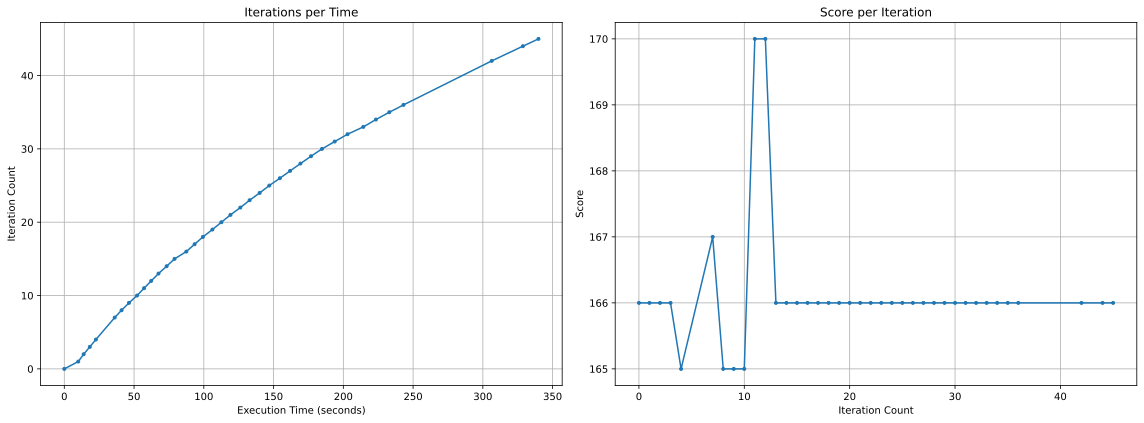

165
{'all': 1431, 'two': 409, 'one': 1022, 't': 173}


In [5]:
circuit = None
for zx_circuit in pyzx_circuits:
    if hasattr(zx_circuit, 'name') and zx_circuit.name == "adder_8":
        circuit = zx_circuit
        break

if circuit is not None:
    print(f"回路名: {circuit.name}")
    print(circuit.stats_dict())
else:
    print("回路は見つかりませんでした。")


g = pyzx.simplify.teleport_reduce(circuit.to_graph())
pyzx.draw(g,labels=True)
initial_graph = g
pyzx.simplify.spider_simp(initial_graph)
pyzx.simplify.to_gh(initial_graph)
pyzx.simplify.id_simp(initial_graph)

print("初期グラフが生成されました。")
initial_score = score_t(initial_graph)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer_T(
    initial_temp=10.0,
    final_temp=1,
    cooling_rate=0.95,
)

best_graph, best_score_result, score_history = sa.solve(
    initial_state=initial_graph,
    evaluate_func=score_t,
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score}")
print(f"最終的な最良スコア: {best_score_result}")

print("\n最適化後のグラフ:")
pyzx.draw(best_graph, labels=True)

# 4. 新しいグラフ描画関数を呼び出す
print("\n--- パフォーマンスグラフ ---")
plot_graphs2(score_history)
print(score_t(best_graph))
print(get_gate_num(best_graph))

回路名: gf2^4_mult
{'name': 'gf2^4_mult', 'qubits': 12, 'gates': 243, 'tcount': 112, 'clifford': 131, 'twoqubit': 99, 'cnot': 99, 'had': 32, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}


初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 61
  T=10.0000, iter=1, 遷移回数=1 -> 新しい最良スコア: 58
温度更新: 9.5000, 現在スコア: 58, 最良スコア: 58
  T=9.5000, iter=2, 遷移回数=2 -> 新しい最良スコア: 56
温度更新: 9.0250, 現在スコア: 56, 最良スコア: 56
  T=9.0250, iter=3, 遷移回数=3 -> 新しい最良スコア: 52
温度更新: 8.5738, 現在スコア: 52, 最良スコア: 52
温度更新: 8.1451, 現在スコア: 52, 最良スコア: 52
  T=8.1451, iter=5, 遷移回数=5 -> 新しい最良スコア: 50
温度更新: 7.7378, 現在スコア: 50, 最良スコア: 50
温度更新: 7.3509, 現在スコア: 54, 最良スコア: 50
温度更新: 6.9834, 現在スコア: 54, 最良スコア: 50
温度更新: 6.6342, 現在スコア: 51, 最良スコア: 50
温度更新: 6.3025, 現在スコア: 51, 最良スコア: 50
温度更新: 5.9874, 現在スコア: 52, 最良スコア: 50
温度更新: 5.6880, 現在スコア: 53, 最良スコア: 50
温度更新: 5.4036, 現在スコア: 53, 最良スコア: 50
温度更新: 5.1334, 現在スコア: 54, 最良スコア: 50
温度更新: 4.8767, 現在スコア: 52, 最良スコア: 50
温度更新: 4.6329, 現在スコア: 50, 最良スコア: 50
温度更新: 4.4013, 現在スコア: 52, 最良スコア: 50
温度更新: 4.1812, 現在スコア: 52, 最良スコア: 50
温度更新: 3.9721, 現在スコア: 52, 最良スコア: 50
温度更新: 3.7735, 現在スコア: 51, 最良スコア: 50
  T=3.7735, iter=20, 遷移回数=17 -> 新しい最良スコア: 48
温度更新: 3.5849, 現在スコア: 48, 最良スコア: 48
温度更新: 3.4056, 現在スコア: 50, 最良スコア: 48
温度更


--- パフォーマンスグラフ ---


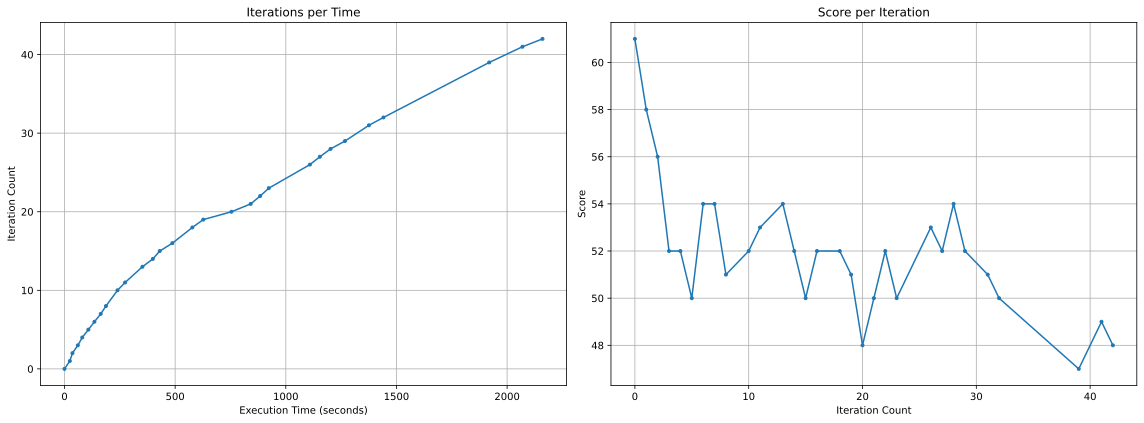

52
{'all': 400, 'two': 113, 'one': 287, 't': 68}


In [24]:

circuit = None
for zx_circuit in pyzx_circuits:
    if hasattr(zx_circuit, 'name') and zx_circuit.name == "gf2^4_mult":
        circuit = zx_circuit
        break

if circuit is not None:
    print(f"回路名: {circuit.name}")
    print(circuit.stats_dict())
else:
    print("回路は見つかりませんでした。")

g = pyzx.simplify.teleport_reduce(circuit.to_graph())
pyzx.draw(g,labels=True)
initial_graph = g
pyzx.simplify.spider_simp(initial_graph)
pyzx.simplify.to_gh(initial_graph)
pyzx.simplify.id_simp(initial_graph)

print("初期グラフが生成されました。")
initial_score = score_t(initial_graph)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer_T(
    initial_temp=10.0,
    final_temp=1,
    cooling_rate=0.95,
)

best_graph, best_score_result, score_history = sa.solve(
    initial_state=initial_graph,
    evaluate_func=score_t,
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score}")
print(f"最終的な最良スコア: {best_score_result}")

print("\n最適化後のグラフ:")
pyzx.draw(best_graph, labels=True)

# 4. 新しいグラフ描画関数を呼び出す
print("\n--- パフォーマンスグラフ ---")
plot_graphs2(score_history)
print(score_t(best_graph))
print(get_gate_num(best_graph))

In [ ]:
pyzx.draw(best_graph,labels=True)
for i in range(30):
    print(score_t(best_graph))


48
52
50
52
53
52
52
50
52
52
52
54
52
55
50
53
52
51
50
50
49
50
54
51
50
50
54
52
53
51


In [34]:
pyzx.draw(best_graph,labels=True)
for i in range(30):
    g_tmp = best_graph.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    c = pyzx.optimize.phase_block_optimize(c)
    if c.tcount() <= 48:
        print(c.tcount())
        pyzx.draw(c,labels=True)
        break

46


In [35]:
print(c.stats_dict())

{'name': '', 'qubits': 12, 'gates': 254, 'tcount': 46, 'clifford': 208, 'twoqubit': 190, 'cnot': 159, 'had': 8, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}


In [40]:
circuit_2 = None
for zx_circuit in pyzx_circuits:
    if hasattr(zx_circuit, 'name') and zx_circuit.name == "gf2^4_mult":
        circuit_2 = zx_circuit
        break

if circuit_2 is not None:
    print(f"回路名: {circuit_2.name}")
    print(circuit_2.stats_dict())
else:
    print("回路は見つかりませんでした。")

pyzx.draw(circuit_2,labels=True)
for i in range(10):
    circuit_3 = copy.deepcopy(circuit_2)
    g2 = pyzx.simplify.teleport_reduce(circuit_3.to_graph())
    circuit_chu = pyzx.Circuit.from_graph(g2)
    pyzx.draw(circuit_chu,labels=True)

    c_aft2 = pyzx.optimize.phase_block_optimize(circuit_chu)
    print(c_aft2.stats())
    pyzx.draw(c_aft2,labels=True)

回路名: gf2^4_mult
{'name': 'gf2^4_mult', 'qubits': 12, 'gates': 243, 'tcount': 112, 'clifford': 131, 'twoqubit': 99, 'cnot': 99, 'had': 32, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}


Circuit  on 12 qubits with 256 gates.
        52 is the T-count
        204 Cliffords among which
        185 2-qubit gates (150 CNOT, 35 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 260 gates.
        51 is the T-count
        209 Cliffords among which
        193 2-qubit gates (160 CNOT, 33 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 272 gates.
        55 is the T-count
        217 Cliffords among which
        200 2-qubit gates (169 CNOT, 31 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 247 gates.
        52 is the T-count
        195 Cliffords among which
        177 2-qubit gates (149 CNOT, 28 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 269 gates.
        55 is the T-count
        214 Cliffords among which
        199 2-qubit gates (163 CNOT, 36 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 261 gates.
        54 is the T-count
        207 Cliffords among which
        189 2-qubit gates (152 CNOT, 37 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 272 gates.
        49 is the T-count
        223 Cliffords among which
        205 2-qubit gates (173 CNOT, 32 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 281 gates.
        49 is the T-count
        232 Cliffords among which
        214 2-qubit gates (181 CNOT, 33 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 284 gates.
        52 is the T-count
        232 Cliffords among which
        215 2-qubit gates (185 CNOT, 30 other) and
        8 Hadamard gates.


Circuit  on 12 qubits with 293 gates.
        53 is the T-count
        240 Cliffords among which
        223 2-qubit gates (191 CNOT, 32 other) and
        8 Hadamard gates.


In [ ]:
#!chmod +x ../TOpt 
#!ls -l ..
pyzx.settings.topt_command = ["wsl","../TOpt"]
circuit = None
for zx_circuit in pyzx_circuits:
    if hasattr(zx_circuit, 'name') and zx_circuit.name == "csla_mux_3_original":
        circuit = zx_circuit
        break

if circuit is not None:
    print(f"回路名: {circuit.name}")
    print(circuit.stats_dict())
else:
    print("回路は見つかりませんでした。")


g = pyzx.simplify.teleport_reduce(circuit.to_graph())
pyzx.draw(g,labels=True)
c = pyzx.Circuit.from_graph(g)
print(c.stats())

pyzx.draw(c,labels=True)

for i in range(10):
    c_aft = pyzx.optimize.phase_block_optimize(c.copy())
    print(c_aft.stats())
    pyzx.draw(c,labels=True)

回路名: csla_mux_3_original
{'name': 'csla_mux_3_original', 'qubits': 15, 'gates': 170, 'tcount': 70, 'clifford': 100, 'twoqubit': 80, 'cnot': 80, 'had': 20, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}


Circuit  on 15 qubits with 164 gates.
        62 is the T-count
        102 Cliffords among which
        80 2-qubit gates (80 CNOT, 0 other) and
        20 Hadamard gates.


Circuit  on 15 qubits with 292 gates.
        50 is the T-count
        242 Cliffords among which
        207 2-qubit gates (126 CNOT, 81 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 279 gates.
        47 is the T-count
        232 Cliffords among which
        196 2-qubit gates (128 CNOT, 68 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 281 gates.
        49 is the T-count
        232 Cliffords among which
        193 2-qubit gates (134 CNOT, 59 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 281 gates.
        50 is the T-count
        231 Cliffords among which
        199 2-qubit gates (153 CNOT, 46 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 296 gates.
        50 is the T-count
        246 Cliffords among which
        206 2-qubit gates (147 CNOT, 59 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 264 gates.
        48 is the T-count
        216 Cliffords among which
        183 2-qubit gates (123 CNOT, 60 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 242 gates.
        45 is the T-count
        197 Cliffords among which
        166 2-qubit gates (124 CNOT, 42 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 255 gates.
        48 is the T-count
        207 Cliffords among which
        171 2-qubit gates (113 CNOT, 58 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 267 gates.
        47 is the T-count
        220 Cliffords among which
        187 2-qubit gates (138 CNOT, 49 other) and
        14 Hadamard gates.


Circuit  on 15 qubits with 244 gates.
        49 is the T-count
        195 Cliffords among which
        156 2-qubit gates (113 CNOT, 43 other) and
        14 Hadamard gates.


回路名: csla_mux_3_original
{'name': 'csla_mux_3_original', 'qubits': 15, 'gates': 170, 'tcount': 70, 'clifford': 100, 'twoqubit': 80, 'cnot': 80, 'had': 20, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}


初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 49
  T=10.0000, iter=1, 遷移回数=1 -> 新しい最良スコア: 48
温度更新: 9.5000, 現在スコア: 48, 最良スコア: 48
温度更新: 9.0250, 現在スコア: 49, 最良スコア: 48
温度更新: 8.5738, 現在スコア: 48, 最良スコア: 48
温度更新: 8.1451, 現在スコア: 48, 最良スコア: 48
  T=8.1451, iter=5, 遷移回数=5 -> 新しい最良スコア: 47
温度更新: 7.7378, 現在スコア: 47, 最良スコア: 47
温度更新: 7.3509, 現在スコア: 49, 最良スコア: 47
温度更新: 6.9834, 現在スコア: 48, 最良スコア: 47
温度更新: 6.6342, 現在スコア: 48, 最良スコア: 47
温度更新: 6.3025, 現在スコア: 48, 最良スコア: 47
温度更新: 5.9874, 現在スコア: 47, 最良スコア: 47
温度更新: 5.6880, 現在スコア: 48, 最良スコア: 47
温度更新: 5.4036, 現在スコア: 49, 最良スコア: 47
温度更新: 5.1334, 現在スコア: 49, 最良スコア: 47
  T=5.1334, iter=14, 遷移回数=13 -> 新しい最良スコア: 46
温度更新: 4.8767, 現在スコア: 46, 最良スコア: 46
温度更新: 4.6329, 現在スコア: 49, 最良スコア: 46
温度更新: 4.4013, 現在スコア: 48, 最良スコア: 46
温度更新: 4.1812, 現在スコア: 48, 最良スコア: 46
  T=4.1812, iter=18, 遷移回数=17 -> 新しい最良スコア: 44
温度更新: 3.9721, 現在スコア: 44, 最良スコア: 44
温度更新: 3.7735, 現在スコア: 49, 最良スコア: 44
温度更新: 3.5849, 現在スコア: 49, 最良スコア: 44
温度更新: 3.4056, 現在スコア: 50, 最良スコア: 44
温度更新: 3.2353, 現在スコア: 46, 最良スコア: 44
温度更新: 3.0


--- パフォーマンスグラフ ---


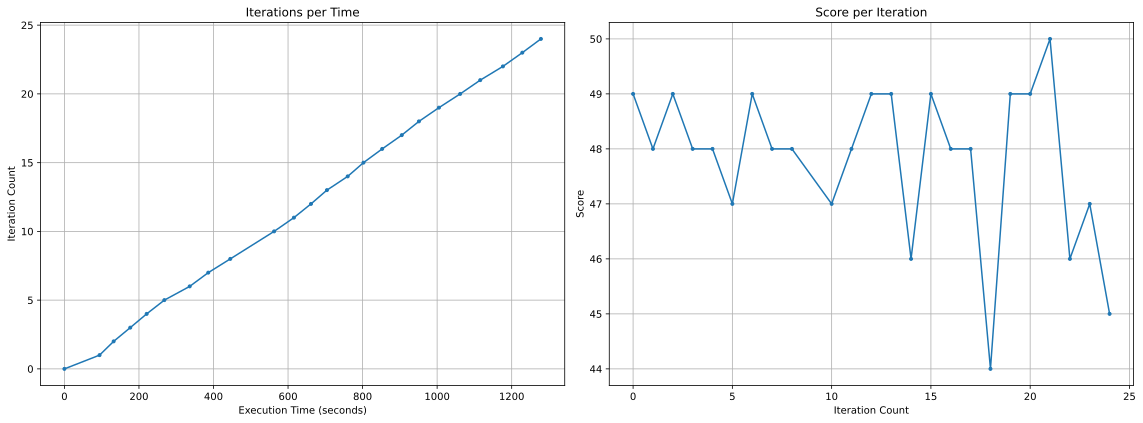

47
{'all': 274, 'two': 79, 'one': 195, 't': 62}


In [106]:
#csla_myx_3_original

circuit = None
for zx_circuit in pyzx_circuits:
    if hasattr(zx_circuit, 'name') and zx_circuit.name == "csla_mux_3_original":
        circuit = zx_circuit
        break

if circuit is not None:
    print(f"回路名: {circuit.name}")
    print(circuit.stats_dict())
else:
    print("回路は見つかりませんでした。")

g = pyzx.simplify.teleport_reduce(circuit.to_graph())
pyzx.draw(g,labels=True)
initial_graph2 = g
pyzx.simplify.spider_simp(initial_graph2)
pyzx.simplify.to_gh(initial_graph2)
pyzx.simplify.id_simp(initial_graph2)

print("初期グラフが生成されました。")
initial_score2 = score_t(initial_graph2)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer_T(
    initial_temp=10.0,
    final_temp=3,
    cooling_rate=0.95,
)

best_graph2, best_score_result2, score_history2 = sa.solve(
    initial_state=initial_graph2,
    evaluate_func=score_t,
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score2}")
print(f"最終的な最良スコア: {best_score_result2}")

print("\n最適化後のグラフ:")
pyzx.draw(best_graph2, labels=True)

# 4. 新しいグラフ描画関数を呼び出す
print("\n--- パフォーマンスグラフ ---")
plot_graphs2(score_history2)
print(score_t(best_graph2))
print(get_gate_num(best_graph2))

In [107]:
pyzx.draw(best_graph2,labels=True)
for i in range(30):
    g_tmp = best_graph2.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    c = pyzx.optimize.phase_block_optimize(c)
    print(c.stats())
    if c.tcount() <= 44:
        print(c.tcount())

        
        pyzx.draw(c,labels=True)
        break

Circuit  on 15 qubits with 279 gates.
        48 is the T-count
        231 Cliffords among which
        195 2-qubit gates (139 CNOT, 56 other) and
        14 Hadamard gates.
Circuit  on 15 qubits with 246 gates.
        46 is the T-count
        200 Cliffords among which
        164 2-qubit gates (118 CNOT, 46 other) and
        14 Hadamard gates.
Circuit  on 15 qubits with 291 gates.
        49 is the T-count
        242 Cliffords among which
        207 2-qubit gates (135 CNOT, 72 other) and
        14 Hadamard gates.
Circuit  on 15 qubits with 285 gates.
        48 is the T-count
        237 Cliffords among which
        202 2-qubit gates (149 CNOT, 53 other) and
        14 Hadamard gates.


KeyboardInterrupt: 

In [ ]:
#実験
c = generate_H_S_CNOT_T_circuit(3, 10, p_t=0.08, seed=1000) 
print(c.stats())

#pre proc
g = c.to_graph()
pyzx.simplify.to_gh(g)
pyzx.simplify.spider_simp(g)

pyzx.simplify.id_simp(g)

pyzx.draw(g,labels=True)

pyzx.simplify.id_simp(g)


#pyzx.local_search.congruences.apply_rand_lc(g)
#pyzx.local_search.congruences.apply_rand_pivot(g)
#pyzx.local_search.congruences.apply_rand_pivot(g)
#pyzx.local_search.congruences.lc_cong2(g,15)
pyzx.local_search.congruences.lc_cong(g,15)
pyzx.draw(g,labels=True)
#pyzx.simplify.id_simp(g, quiet=True)
#pyzx.simplify.spider_simp(g, quiet=True)

pyzx.draw(g,labels=True)
c = pyzx.extract.streaming_extract(g)
c = pyzx.optimize.basic_optimization(c)
pyzx.draw(c,labels=True)
print(c.stats())

Circuit  on 3 qubits with 10 gates.
        0 is the T-count
        10 Cliffords among which
        4 2-qubit gates (4 CNOT, 0 other) and
        3 Hadamard gates.


This function is deprecated. Call extract_circuit() instead.


Exception: No extractable vertex found. Something went wrong

In [67]:
#実験
import pyzx.gflow
from pyzx.rules import apply_rule,lcomp

c = generate_H_S_CNOT_T_circuit(3, 20, p_t=0.08, seed=1000) 
print(c.stats())

#pre proc
g = c.to_graph()
pyzx.simplify.to_gh(g)
pyzx.simplify.spider_simp(g)
pyzx.simplify.id_simp(g)
pyzx.draw(g,labels=True)

#pyzx.local_search.congruences.apply_rand_pivot(g)
#pyzx.local_search.congruences.apply_rand_pivot(g)
#pyzx.local_search.congruences.unfuse(g,5)
#pyzx.local_search.congruences.lc_cong2(g,15)
#pyzx.local_search.congruences.lc_cong(g,3)
#pyzx.local_search.congruences.apply_rand_lc(g) #lc_cong2


pyzx.draw(g,labels=True)
#apply_rule(g, lcomp, [[50, list(g.neighbors(50))]])

print(pyzx.gflow.gflow(g))
#pyzx.simplify.id_simp(g, quiet=True)
#pyzx.simplify.spider_simp(g, quiet=True)


pyzx.draw(g,labels=True)
c = pyzx.extract.streaming_extract(g)
c = pyzx.optimize.basic_optimization(c)
#pyzx.draw(c,labels=True)
print(c.stats())

Circuit  on 3 qubits with 20 gates.
        1 is the T-count
        19 Cliffords among which
        7 2-qubit gates (7 CNOT, 0 other) and
        6 Hadamard gates.


({24: 5, 11: 5, 22: 5, 14: 4, 21: 4, 4: 3, 8: 3, 15: 3, 7: 2, 5: 1, 3: 0}, {14: {24, 22}, 21: {24}, 4: {21, 14}, 8: {11, 14}, 15: {21}, 7: {15}, 5: {7}, 3: {5}})


This function is deprecated. Call extract_circuit() instead.
Circuit  on 3 qubits with 17 gates.
        1 is the T-count
        16 Cliffords among which
        7 2-qubit gates (7 CNOT, 0 other) and
        3 Hadamard gates.


In [ ]:
#neighbor unfusion 実験
import pyzx.gflow
from pyzx.rules import apply_rule,lcomp
from pyzx.utils import VertexType, EdgeType
from fractions import Fraction

c = generate_H_S_CNOT_T_circuit(3, 20, p_t=0.08, seed=1000) 
print(c.stats())

#pre proc
g = c.to_graph()
pyzx.simplify.to_gh(g)
pyzx.simplify.spider_simp(g)
pyzx.simplify.id_simp(g)
pyzx.draw(g,labels=True)

#pyzx.local_search.congruences.apply_rand_pivot(g)
#pyzx.local_search.congruences.apply_rand_pivot(g)
#pyzx.local_search.congruences.unfuse(g,5)
#pyzx.local_search.congruences.lc_cong2(g,15)
#pyzx.local_search.congruences.lc_cong(g,3)
#pyzx.local_search.congruences.apply_rand_lc(g) #lc_cong2


pyzx.draw(g,labels=True)
g.add_vertex(
        ty=VertexType.Z)
g.add_vertex(
        ty=VertexType.Z)
g.remove_edge(g.edge(15,21))
g.add_edge(g.edge(15,33),edgetype=EdgeType.HADAMARD)
g.add_edge(g.edge(33,34),edgetype=EdgeType.HADAMARD)
g.add_edge(g.edge(34,21),edgetype=EdgeType.HADAMARD)
g.set_phase(15,phase = Fraction(1,2))
g.set_phase(34,phase = Fraction(3,2))
pyzx.draw(g,labels=True)
pyzx.rules.apply_rule(g,lcomp,[[15, list(g.neighbors(15))]])
#apply_rule(g, lcomp, [[50, list(g.neighbors(50))]])

print(pyzx.gflow.gflow(g))
#pyzx.simplify.id_simp(g, quiet=True)
#pyzx.simplify.spider_simp(g, quiet=True)


pyzx.draw(g,labels=True)
c = pyzx.extract.streaming_extract(g)
c = pyzx.optimize.basic_optimization(c)
#pyzx.draw(c,labels=True)
print(c.stats())

Circuit  on 3 qubits with 20 gates.
        1 is the T-count
        19 Cliffords among which
        7 2-qubit gates (7 CNOT, 0 other) and
        6 Hadamard gates.


({24: 6, 11: 6, 22: 6, 14: 5, 21: 5, 34: 4, 8: 4, 33: 3, 4: 2, 7: 2, 5: 1, 3: 0}, {14: {24, 22}, 21: {24}, 34: {21}, 8: {11, 14}, 33: {34}, 4: {33, 11}, 7: {33}, 5: {7}, 3: {5}})


This function is deprecated. Call extract_circuit() instead.
Circuit  on 3 qubits with 24 gates.
        1 is the T-count
        23 Cliffords among which
        10 2-qubit gates (6 CNOT, 4 other) and
        5 Hadamard gates.
